# FAST ROADMAP

## About



`ITS_LIVE_TOOL` is a package designed to aid users working with the [Inter-mission Time Series of Land Ice Velocity and Elevation](link) (ITS_LIVE) dataset. The package provides functions for accessing data as well as various methods to process ITS_LIVE observations. This notebook will demonstrate various elements of the package and walk through the steps of a typical workflow using ITS_LIVE_TOOL. 

## Overview 

```{note}
keep this overview here? or move to readme doc
```
The tools in the package fall into two main categories: 1) data access + organization, 2) data processing. 

### Data Access + Organization

#### 1. Interactive map widget

This is an interactive widget design to streamline access ITS_LIVE image pair ice velocity time series. 

#### 2. Organization: `Glacier`, `Glacier_Centerline`, `Glacier_Point` objects

These are provided to store and keep track of different types of data related to individual units of analysis such as points, centerlines or full glacier surface areas. 

This roadmap document will first demonstrate data access and organization tools before demonstrating the processing tools. 

### Data Processing

We demonstrate and make available two processing routines. Be sure to check out the accompanying [book]() and consider if either of these are appropriate for your data and use case. Note that these methods are in active development and thus should be considered in *beta* phase. Please perform your own data inspection and due diligence if implementing these methods. 

#### Inversion

**to add**
Description -- link to full description and examples


#### Gaussian Process Regression 

**to add**
Description -- link to full description and examples


### Processing

We demonstrate and make available two processing routines. Be sure to check out the accompanying [book]() and consider if either of these are appropriate for your data and use case. Note that these methods are in active development and thus should be considered in *beta* phase. Please perform your own data inspection and due diligence if implementing these methods. 

In [ ]:
from ITS_LIVE_TOOL import datacube_tools, interactive, obj_setup

In [ ]:
import os
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd
import geopandas as gpd
import matplotlib.path as mplp
import ipyleaflet as ipyl
from ipyleaflet import WMSLayer
import ipywidgets as ipyw
import json
import pandas as pd
from ipyleaflet import Map, WMSLayer, basemaps
from ipywidgets import HTML
from owslib.wms import WebMapService

## Install

Install this package using the below command 

```{note}
someday we hope to have a pip or conda install, for now use pip install git+ github repo url
```

# Section 1: Data Access + Organization

### How to use

There are two ways to access data using ITS_LIVE_TOOL. The first way is through the interactive widget. This is great for exploratory analysis. The second way is by specifying an RGI ID and point coordinates manually. This is useful if you already know which glacier(s) you want to examine and simply want to pass a list of RGI IDs and coordinates. We'll first demonstrate using the interactive widget.

### Interactive data selection widget

First, use the interactive map to select data. Do this by right- and left-clicking on the map location where you'd like to access data. 
This will return an object containing the coordinates of the point you clicked, a `geopandas.GeoDataFrame` of the [RGI7](http://www.glims.org/rgi_user_guide/welcome.html) data for that glacier and the URL of the ITS_LIVE granule covering the clicked point. 

```{note}
If the glacier you want to study lies in multiple ITS_LIVE granules, or you'd like to look at multiple glaciers, click in multiple points and the output objects will be appended with each click. 
```

In [ ]:
#| eval: false
#| output: false

data_map = interactive.Widget()

In [ ]:
#| eval: false
#| output: false

data_map.display()

### Create data objects

Once you have made your selection(s) on the map, use the following methods to create objects that will store your data

#### If you've only selected one glacier, create individual objects as follows: 

In [ ]:
data_map.urls

['http://its-live-data.s3.amazonaws.com/datacubes/v2/N50W140/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y350000.zarr',
 'http://its-live-data.s3.amazonaws.com/datacubes/v2/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-3250000_Y350000.zarr',
 'http://its-live-data.s3.amazonaws.com/datacubes/v2/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr',
 'http://its-live-data.s3.amazonaws.com/datacubes/v2/N60W130/ITS_LIVE_vel_EPSG3413_G0120_X-3250000_Y250000.zarr']

In [ ]:
glacier = obj_setup.create_glacier_from_click(data_map, 0)

In [ ]:
#glacier.itslive_url

'http://its-live-data.s3.amazonaws.com/datacubes/v2/N50W140/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y350000.zarr'

In [ ]:
glacier_point = obj_setup.create_glacier_point_from_click(data_map, 0, 'phony label')

original xy [-143.04795214410368, 60.37791914446092] 4326 maps to datacube (-3247134.1548154885, 459126.5490621218) EPSG:3413
original xy [-143.04795214410368, 60.37791914446092] 4326 maps to datacube (-3247134.1548154885, 459126.5490621218) EPSG:3413
subset and load at  63.19 seconds



KeyboardInterrupt



In [ ]:
glacier_centerline = obj_setup.create_glacier_centerline_from_click(data_map, 0)

As you can see, these objects all store data related to the same glacier that was selected, but at different spatial scales. The `glacier` object contains an RGIID, name and the RGI outline and attributes for that glacier. 

In [ ]:
glacier.outline_prj

,id,CENLON,ZMAX,BGNDATE,ZMIN,RGIID,ASPECT,CENLAT,SLOPE,ZMED,...,TERMTYPE,O2REGION,STATUS,ENDDATE,FORM,SURGING,GLIMSID,O1REGION,NAME,geometry
0,RGI_Alaska.13631,-142.072,5381,20100910,3,RGI60-01.13635,273,60.461,9,1525,...,2,5,0,-9999999,0,9,G217928E60461N,1,Bering Glacier,"MULTIPOLYGON (((506808.975 6723108.546, 506874..."


The `glacier_point` object also has the RGI ID and name inherited from the map widget but additionally contains ITS_LIVE image pair velocity time series data for the selected point as well as a 3x3 pixel cube surrounding the point. 

In [ ]:
glacier_point.cube_around_point

<xarray.Dataset>
Dimensions:                (mid_date: 21894, x: 3, y: 4)
Coordinates:
  * mid_date               (mid_date) datetime64[ns] 2020-10-27T20:55:56.2010...
  * x                      (x) float64 -3.247e+06 -3.247e+06 -3.247e+06
  * y                      (y) float64 4.593e+05 4.592e+05 4.591e+05 4.589e+05
    step_count             (mid_date) int64 0 5 12 14 ... 76928 76941 76952
    mapping                int64 0
Data variables:
    v                      (mid_date, y, x) float32 nan 182.0 nan ... 11.0 nan
    vy                     (mid_date, y, x) float32 nan -131.0 nan ... 11.0 nan
    vx                     (mid_date, y, x) float32 nan -126.0 nan ... 2.0 nan
    v_error                (mid_date, y, x) float32 nan 53.0 nan ... nan 6.0 nan
    satellite_img1         (mid_date) object '2A' '2A' '2A' '2B' ... '7' '7' '7'
    satellite_img2         (mid_date) object '2A' '2A' '2B' '2B' ... '8' '8' '8'
    acquisition_date_img1  (mid_date) datetime64[ns] 2020-10-17T20:55:01 ... ...
    acquisition_date_img2  (mid_date) datetime64[ns] 2020-11-06T20:56:51.0000...
    img_separation         (mid_date) float64 21.0 500.0 535.0 ... 217.0 312.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:55:04
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N60W140/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N60W140/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The `glacier_centerline` object contains the same RGIID and name information as the first two objects. In addition, it contains OGGM centerline data that are stored as geopandas GeodataFrames.

In [ ]:
glacier_centerline.main_centerline

,RGIID,SEGMENT_ID,LE_SEGMENT,MAIN,geometry
19617,RGI60-01.13635,40,212562.0,1,"LINESTRING (522733.337 6719455.665, 522730.077..."


Each of these objects are meant to act as cotainers to intuitively and efficiently store different types of data as you process and continue to work with ITS_LIVE data. 

The previous steps demonstrated the data access and organization functionality of ITS_LIVE_TOOl. The subsequent sections of this notebook will demonstrate different processing methodologies for working with this dataset. 

#### If you've selected multiple glaciers, follow these examples:

In [ ]:
#glacier0, glacier1 = obj_setup.create_multiple_glacier_objs(data_map)[0], obj_setup.create_multiple_glacier_objs(data_map)[1]

In [ ]:
#glacier_point_ls = obj_setup.create_multiple_glacier_point_objs(data_map)
#glacier_pt0, glacier_pt1 = glacier_point_ls[0], glacier_point_ls[1]

original xy [-141.34499544222683, 60.45529919026818] 4326 maps to datacube (-3250454.7365773427, 361437.5235576865) EPSG:3413
original xy [-141.34499544222683, 60.45529919026818] 4326 maps to datacube (-3250454.7365773427, 361437.5235576865) EPSG:3413
subset and load at  58.26 seconds
original xy [-141.32575672759108, 60.65848956101137] 4326 maps to datacube (-3227246.8706271336, 357759.90272181097) EPSG:3413
original xy [-141.32575672759108, 60.65848956101137] 4326 maps to datacube (-3227246.8706271336, 357759.90272181097) EPSG:3413
subset and load at  60.11 seconds


### Manually create `Glacier`, `Glacier_Point`, `Glacier_Centerline` objects

Create objects that contain the clicked data from the above map widget.  
These are `coords`, `gpdf`, `urls`  


In [ ]:
coords, gpdf, urls = obj_setup.return_clicked_info(data_map)

You have 2 glaciers selected


In [ ]:
coords

[[60.37791914446092, -143.04795214410368],
 [60.36705675717361, -143.64435229781114]]

In [ ]:
label = 'label'
var_ls = ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']

In [ ]:
glacier_manual = obj_setup.Glacier(gpdf[0]['NAME'].iloc[0], gpdf[0]['RGIID'].iloc[0], str(gpdf[0].estimate_utm_crs()), 'manual', rgi_outline_from_widget = None)

In [ ]:
glacier_manual.name

'Bering Glacier'

In [ ]:
glacier_manual.rgi_id

'RGI60-01.13635'

In [ ]:
glacier_manual.outline_prj.crs

<Projected CRS: EPSG:32607>
Name: WGS 84 / UTM zone 7N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 144°W and 138°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Yukon. United States (USA) - Alaska (AK).
- bounds: (-144.0, 0.0, -138.0, 84.0)
Coordinate Operation:
- name: UTM zone 7N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
glacier_pt = obj_setup.Glacier_Point(glacier.name, 'acc. zone', glacier.rgi_id, [coords[0][1], coords[0][0]], var_ls)

original xy [-143.04795214410368, 60.37791914446092] 4326 maps to datacube (-3247134.1548154885, 459126.5490621218) EPSG:3413
original xy [-143.04795214410368, 60.37791914446092] 4326 maps to datacube (-3247134.1548154885, 459126.5490621218) EPSG:3413
subset and load at  62.53 seconds


In [ ]:
glacier_centerline = obj_setup.Glacier_Centerline('Jorge Montt', 'RGI60-17.06074')

### `Glacier_Point`

This object inherits name and RGIID attributes from the `Glacier` object described aboev (or you can input them manually). It takes the coordinate information specified in the widget and list of variables of interest and returns an object containing ITS_LIVE image pair time series datasets for the specified point anda 3x3 pixel cube surrounding the specified point. Check out the docs for a description of all of the attributes and methods associated with this object. 

In [ ]:
coords

[[61.445551290803365, -147.96202722979135]]

In [ ]:
glacier_pt = obj_setup.Glacier_Point(glacier.name, 'acc. zone', glacier.rgi_id, [coords[0][1], coords[0][0]], var_ls)

original xy [-147.96202722979135, 61.445551290803365] 4326 maps to datacube (-3075868.4013177734, 707973.3167825146) EPSG:3413
original xy [-147.96202722979135, 61.445551290803365] 4326 maps to datacube (-3075868.4013177734, 707973.3167825146) EPSG:3413
subset and load at  48.89 seconds


In [ ]:
glacier_pt.cube_around_point

<xarray.Dataset>
Dimensions:                (mid_date: 13831, x: 3, y: 3)
Coordinates:
  * mid_date               (mid_date) datetime64[ns] 2020-02-26T21:15:44.1906...
  * x                      (x) float64 -3.076e+06 -3.076e+06 -3.076e+06
  * y                      (y) float64 7.081e+05 7.079e+05 7.078e+05
    step_count             (mid_date) int64 1 6 7 8 ... 53266 53268 53273 53285
    mapping                int64 0
Data variables:
    v                      (mid_date, y, x) float32 nan nan nan ... nan nan nan
    vy                     (mid_date, y, x) float32 nan nan nan ... nan nan nan
    vx                     (mid_date, y, x) float32 nan nan nan ... nan nan nan
    v_error                (mid_date, y, x) float32 nan nan nan ... nan nan nan
    satellite_img1         (mid_date) object '2B' '5' '2B' '7' ... '7' '8' '8'
    satellite_img2         (mid_date) object '2B' '5' '2B' '7' ... '8' '8' '8'
    acquisition_date_img1  (mid_date) datetime64[ns] 2019-06-26T21:15:19.0000...
    acquisition_date_img2  (mid_date) datetime64[ns] 2020-10-28T21:16:09 ... ...
    img_separation         (mid_date) float64 491.0 305.0 340.0 ... 352.0 17.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               03-Oct-2023 04:28:15
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N60W140/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N60W140/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [ ]:
glacier_pt

<xarray.Dataset>
Dimensions:                (mid_date: 3906, y: 83, x: 83)
Coordinates:
    mapping                int64 0
  * mid_date               (mid_date) datetime64[ns] 2020-01-26T14:27:11.2001...
  * x                      (x) float64 6.017e+05 6.019e+05 ... 6.116e+05
  * y                      (y) float64 4.633e+06 4.633e+06 ... 4.623e+06
    step_count             (mid_date) int64 7 29 30 38 ... 31281 31283 31302
Data variables:
    v                      (mid_date, y, x) float32 37.0 25.0 9.0 ... nan nan
    vy                     (mid_date, y, x) float32 -2.0 -11.0 2.0 ... nan nan
    vx                     (mid_date, y, x) float32 36.0 23.0 9.0 ... nan nan
    v_error                (mid_date, y, x) float32 26.0 26.0 26.0 ... nan nan
    satellite_img1         (mid_date) object '2A' '2A' '1A' '2A' ... '8' '8' '8'
    satellite_img2         (mid_date) object '2A' '2A' '1A' '2B' ... '7' '9' '8'
    acquisition_date_img1  (mid_date) datetime64[ns] 2020-01-01T14:27:30.9999...
    acquisition_date_img2  (mid_date) datetime64[ns] 2020-02-20T14:26:51 ... ...
    img_separation         (mid_date) float64 50.0 260.0 12.0 ... 536.0 16.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 21:36:13
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S40W070/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S40W070/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

### `Glacier_Centerline`

Similarly to the `Glacier_Point` object, a `Glacier_Centerline` object inherits some basic information from a `Glacier` object, but this can also be specified manually if you don't want to create a `Glacier` method beforehand. A `Glacier_Centerline` object has attributes called `centerlines` and `main_centerline`. These are both `Geopandas.GeoDataframe` objects containing OGGM flowline data associated with this glacier. They also contain ITS_LIVE image pair velocity time series clipped to the centerline (**still being implemented**).

In [ ]:
glacier_centerline = obj_setup.Glacier_Centerline('Jorge Montt', 'RGI60-17.06074')

In [ ]:
glacier_centerline

<ITS_LIVE_TOOL.obj_setup.Glacier_Centerline>

Each of these objects are meant to act as cotainers to intuitively and efficiently store different types of data as you process and continue to work with ITS_LIVE data. 

The previous steps demonstrated the data access and organization functionality of ITS_LIVE_TOOl. The subsequent sections of this notebook will demonstrate different processing methodologies for working with this dataset. 

# Section 2: Data Processing

## Filtering + Inspection 

Examples of situations where outlier detection may be necessary. We present 3 methods for outlier detection. 

```{note}
add images of figures from notebook here ? 
```

## Gaussian Process Regression

We demonstrate a method to develop and apply a Gaussian Process model on ITS_LIVE point time series data. Gaussian Process are a non-parametric, Bayesion regression method to model a latent function such as glacier surface velocity with respect to time, given observations of ice movement over different time periods. 

```{note}
This method is in active development and should currently be considered to be in 'beta' mode. We provide an example of its implementation but stress that it may not be suitable to apply in other scenarios. Please carefully inspect your dataset and the model parameters to be sure it is appropriate before using in your workflows
```

### Problem:

ITS_LIVE image pair ice velocity time series provide estimates of ice movement over a broad range of temporal baselines (number of days between image pairs). The estimates describe different types of ice movement given different temporal baselines and contain noise inherent to sensor algorithmic limitations. Given this complex, noisy dataset, we would like to employ a regression approach to reach an estimate of an underlying velocity function with inherent uncertainty quantifications.

### Raw data

![ITS_LIVE velocity observations for a single point](https://github.com/e-marshall/ITS_LIVE_TOOL/blob/main/figs/baltoro_raw_data_example.png?raw=true)

### Gaussian Process model predictions

![Velocity time series predicted by Gaussian Process model based on ITS_LIVE velocity observations](https://github.com/e-marshall/ITS_LIVE_TOOL/blob/main/figs/baltoro_gp_example_results.png?raw=true)

# Section 3: Datacube Inversion


### **Input your parameters below**

*Useful information:*

- GPU generally runs the inversion faster, but might be slower when using the spatial regularization.
- High lambda encouraged for non-surging glacier
- spatial_shape 'cross' is hard-coded because 'ring' would take a lot of RAM and the code would be much more complicated.
- spatial_regularization: False if you want a faster computation, slightly less accurate.

In [6]:
# In case you didn't run the cell that grabs the urls
coords, gpdf, urls = obj_setup.return_clicked_info(data_map)

# In case you haven't created the centerline
glacier_centerline = obj_setup.create_glacier_centerline_from_click(data_map, 0)

###### INPUT YOUR PARAMETERS #######

name_cube = 'Seward' # Name of the dataset

mission = None # 'None' if you want all the data, 'S1' for Sentinel-1 only, 'L' for Landsat only, etc.. .

lamb = 5 # Smoothing coefficient: the higher the value, the more the inversion favors a smooth output. BAD for surging glaciers, GOOD for non-surging glaciers

derivative = 2 # Derivative degree for the inversion. Doesn't change much unless you have a specific reason to choose 1 or 2 (1st or 2nd derivative)

day_interval = 60 # Amount of days in between each inversion value. The higher, the faster the inversion. But you also lose in temporal resolution. 12 here because Sentinel-1 repeat-time is 12.

sdate = '2019-01-01' # Start date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

edate = None # End date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

GPU = True # True if you want to use GPU, False if you want to use CPU

spatial_regularization = False # True if you want to use spatial regularization, False if you only want to use temporal regularization

if spatial_regularization:
    derivative = 2 # It is better to do a central difference scheme than forward difference in this case
    spatial_shape = 'cross' # 'ring' has not been implemented yet, and tests show a huge in increase in computation time
    nb_pts_tot = 5
else:
    nb_pts_tot = 1
    spatial_shape = None

You have 1 glaciers selected


In [20]:
#data_map = interactive.Widget()
#data_map.display()

#### Create dictionnaries to hold variables for each datacube


In [7]:
X_tot, Y_tot, X_valid, Y_valid, data_dict, urls = invert.create_data_dict(urls, mission, lamb, derivative, day_interval, data_map)

#### Get glacier extent in datacubes

In [8]:
for url in tqdm(range(len(urls))):
    X_tot, Y_tot, X_valid, Y_valid = invert.get_extents(urls[url], X_tot, Y_tot, X_valid, Y_valid, mission, lamb, derivative, day_interval, data_map, data_dict)

100%|██████████| 4/4 [05:40<00:00, 85.21s/it]


#### Map the valid indices in a new array


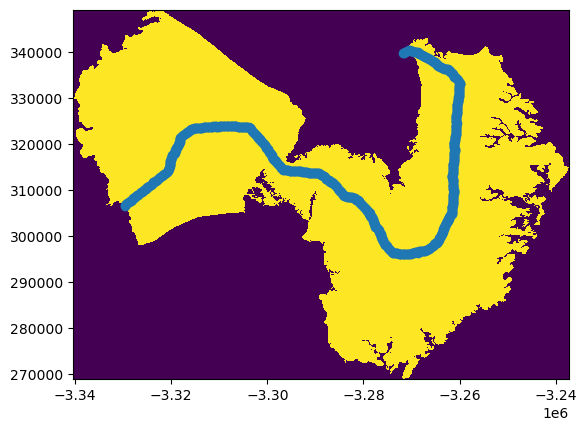

In [12]:
space_interval, min_date, max_date, template, P, neighbor_idx, x_indices_centerline, y_indices_centerline, X_arr, X_MIN, X_MAX, Y_arr, Y_MIN, Y_MAX, x_matches, y_matches = invert.cubes_intersection(X_tot, Y_tot, X_valid, Y_valid, data_dict, urls, spatial_regularization, mission, lamb, derivative, day_interval, sdate, edate, nb_pts_tot, glacier_centerline)

#### Design matrices for the datacubes

In [13]:
reg_mat_space, reg_mat_time, dates_nonum, dates, data_dict = invert.design_matrices(urls, min_date, max_date, mission, lamb, derivative, day_interval, space_interval, sdate, edate, data_dict)

#### Create the host matrices and design matrix bricks

In [23]:
vxInv, vyInv, len_pt_inverted, SRT, SRS, space_reg_mat, time_reg_mat =  invert.extend_Matrices(reg_mat_time, nb_pts_tot, reg_mat_space, spatial_regularization, dates, template)

#### Looper function to run the inversion 

In [ ]:
# Determine the GPU in your system if you have one
if GPU:     
    import torch
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = None

# Run the inversions for vx and vy and populate vxInv, vyInv
for i in tqdm(range(len(y_matches))):

    vxInv, vyInv = invert.looper(i, name_cube, vxInv, vyInv, GPU, spatial_regularization, nb_pts_tot, time_reg_mat, space_reg_mat, len_pt_inverted, data_dict, urls, P, neighbor_idx, x_matches, y_matches, X_arr, X_MIN, X_MAX, Y_arr, Y_MIN, Y_MAX, device, dates_nonum, x_indices_centerline, y_indices_centerline, SRT, SRS)
    
invert.save_dataset(name_cube, vxInv, vyInv, dates_nonum, X_arr, Y_arr, X_MIN, X_MAX, Y_MIN, Y_MAX, x_indices_centerline, y_indices_centerline, data_dict, urls)

  2%|▏         | 5801/261717 [17:05<9:37:39,  7.38it/s] 